In [1]:
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
def print_formatted_struct(data, indent_level=0):
    """
    Recursively print the fields of a MATLAB struct loaded into Python.
    Prints the size of arrays instead of their content.
    """
    indent = '-' * indent_level

    # Check if the data is a structured numpy array
    if isinstance(data, np.ndarray):
        # Check if it's a structured array (with named fields)
        if data.dtype.names is not None:
            for name in data.dtype.names:
                print(f"{indent}{name}:")
                # Recursively print each field
                field_data = data[name][0, 0]  # Adjust indexing based on your data's structure
                print_formatted_struct(field_data, indent_level + 1)
        else:
            # Print the size of the array
            print(f"{indent}[Array of shape {data.shape}]")
    elif isinstance(data, dict):
        for key, value in data.items():
            print(f"{indent}{key}:")
            print_formatted_struct(value, indent_level + 1)
    else:
        # Print summary for other data types
        print(f"{indent}{str(data)}")

In [124]:
class Run:
    def __init__(self, data, markers, cue_id, fs, classes):
        """
        Initialize the Run class with the specified parameters.

        :param data: The data for this run, expected to be in a specific format (e.g., (xxxxx, 15) array)
        :param marker: List of timestamps for when a cue was given
        :param cue_id: List of cue IDs (e.g., 1 for left hand, 2 for right hand)
        """
        self.data = data
        self.markers = markers
        self.cue_id = cue_id
        self.fs = fs
        self.classes = classes
    def __str__(self):
        """
        String representation of the Run instance.
        """
        return f"Run: \n\tData: {self.data.shape}, \n\tMarkers: {self.markers.shape}, \n\tCue IDs: {self.cue_id.shape}, \n\tSampling Frequency: {self.fs}, \n\tClasses: {self.classes}"
    

class Subject:
    def __init__(self, subject_number, num_electrodes, sampling_frequency, classes):
        """
        Initialize the Subject class with the specified parameters.

        :param subject_number: Unique identifier for the subject
        :param num_electrodes: Number of electrodes used
        :param sampling_frequency: Sampling frequency of the data
        """
        self.subject_number = subject_number
        self.num_electrodes = num_electrodes
        self.sampling_frequency = sampling_frequency
        self.runs = []
        self.classes = classes
    def __str__(self):
        """
        String representation of the Subject instance.
        """
        return f"Subject: \n\tSubject Number: {self.subject_number}, \n\tClasses: {self.classes}, \n\tNumber of Runs: {self.num_runs}"

    def __getitem__(self, run_index):
        """
        Retrieve a run by its index using indexing syntax.

        :param run_index: Index of the run in the list of runs
        :return: The Run instance at the specified index
        """
        if 0 <= run_index < len(self.runs):
            return self.runs[run_index]
        else:
            raise IndexError("Run index out of range.")


    def add_run(self, data, markers, cue_id, fs, classes):
        """
        Add a new Run instance to the subject.

        :param data: Data for the run
        :param label: Label for the run
        :param classes: Classes involved in the run
        :param cue: Cue associated with the run
        """
        new_run = Run(data, markers, cue_id, fs, classes)
        self.runs.append(new_run)

    def get_run_data(self, run_index):
        """
        Retrieve the data for a specific run.

        :param run_index: Index of the run in the list
        :return: Data of the specified run
        """
        if 0 <= run_index < len(self.runs):
            return self.runs[run_index].data
        else:
            raise IndexError("Run index out of range.")

    def get_electrode_data(self, run_index, electrode_number):
        """
        Retrieve data for a specific electrode from a specific run.

        :param run_index: Index of the run
        :param electrode_number: Electrode number (0 to num_electrodes - 1)
        :return: Data for the specified electrode in the specified run
        """
        if not (0 <= run_index < len(self.runs)):
            raise IndexError("Run index out of range.")

        run_data = self.runs[run_index].data
        if not (0 <= electrode_number < self.num_electrodes):
            raise ValueError("Invalid electrode number. Must be between 0 and {}.".format(self.num_electrodes - 1))

        return run_data[:, electrode_number]

    @property
    def num_runs(self):
        """
        Return the number of runs for the subject.
        """
        return len(self.runs)

class Subjects:
    def __init__(self):
        """
        Initialize the Subjects class to hold a collection of Subject instances.
        """
        self.subjects = {}
        
    def __str__(self):
        """
        String representation of the Subjects collection, sorted by subject number.
        """
        sorted_subjects = sorted(self.subjects.items(), key=lambda x: x[0])
        subjects_info = [str(subject) for _, subject in sorted_subjects]
        return "Subjects: "+'\n\t'.join(subjects_info)
        
    def __getitem__(self, subject_number):
        """
        Retrieve a subject by its number using indexing syntax.

        :param subject_number: The unique identifier for the subject
        :return: The Subject instance corresponding to the given subject number
        """
        if subject_number in self.subjects:
            return self.subjects[subject_number]
        else:
            raise KeyError(f"Subject with number {subject_number} not found.")

    def add_subject(self, subject):
        """
        Add a new Subject instance to the collection.

        :param subject: An instance of the Subject class
        """
        if subject.subject_number in self.subjects:
            raise ValueError(f"Subject with number {subject.subject_number} already exists.")
        self.subjects[subject.subject_number] = subject

    def get_subject(self, subject_number):
        """
        Retrieve a subject by its number.

        :param subject_number: The unique identifier for the subject
        :return: The Subject instance corresponding to the given subject number
        """
        if subject_number in self.subjects:
            return self.subjects[subject_number]
        else:
            raise ValueError(f"Subject with number {subject_number} not found.")


In [116]:
def get_data(data, run):
    d = data[0,run]
    data = d['X'][0,0]
    labels = d['y'][0,0]
    trial = d['trial'][0,0]
    fs = int(d['fs'][0,0][0,0])
    classes = [d['classes'][0,0][0][i][0] for i in range(len(d['classes'][0,0][0]))]
    return data, labels, trial, fs, classes

In [125]:
subjects = Subjects()
directory = "data/"
for file in os.listdir(os.fsencode(directory)):
    filename = os.fsdecode(file)
    if filename.endswith(".mat"): 
        mat =  loadmat(os.path.join(directory, filename))
        data = mat["data"]
        subjectnumber = int(filename[1:3])
        if data.shape[1]==5:
            signal, markers, cue_id, fs, classes = get_data(data, 0)
            sub = Subject(subjectnumber, signal.shape[1], fs, classes)
            sub.add_run(signal, markers, cue_id, fs, classes)
            for r in range(1, 5):
                signal, markers, cue_id, fs ,classes = get_data(data, r)
                sub.add_run(signal, markers, cue_id, fs, classes)
            subjects.add_subject(sub)
            

In [128]:

print(subjects)


Subjects: Subject: 
	Subject Number: 1, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 2, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 3, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 4, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 5, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 6, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 7, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 8, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 9, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 10, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 11, 
	Classes: ['right hand', 'feet'], 
	Number of Runs: 5
	Subject: 
	Subject Number: 12, 
	Classes: 

# MNE


In [135]:
import mne

<Info | 7 non-empty values
 bads: []
 ch_names: EEG01, EEG02, EEG03, EEG04, EEG05, EEG06, EEG07, EEG08, EEG09, ...
 chs: 15 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 15
 projs: []
 sfreq: 512.0 Hz
>
Creating RawArray with float64 data, n_channels=15, n_times=114176
    Range : 0 ... 114175 =      0.000 ...   222.998 secs
Ready.


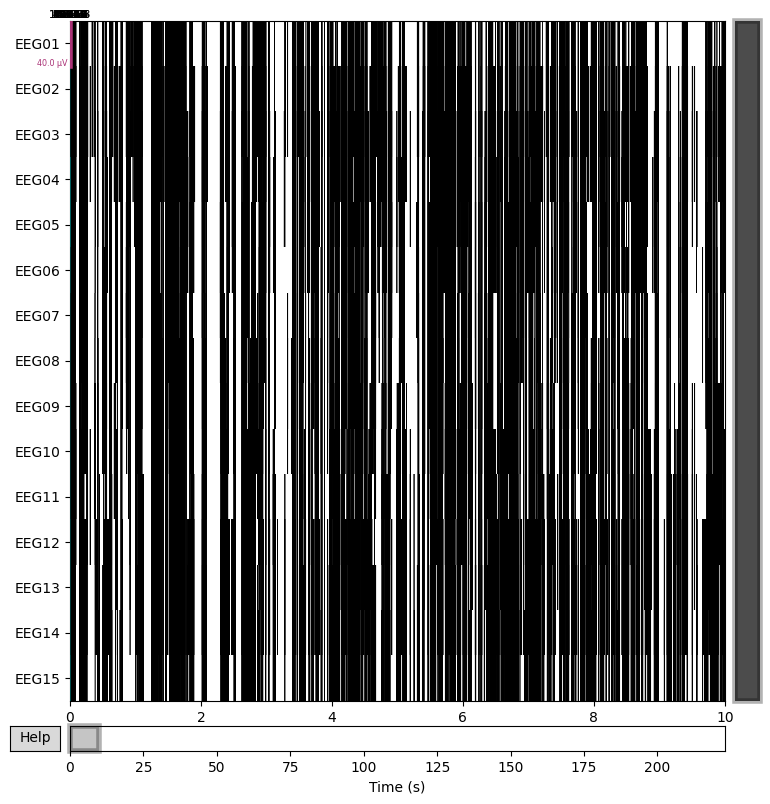

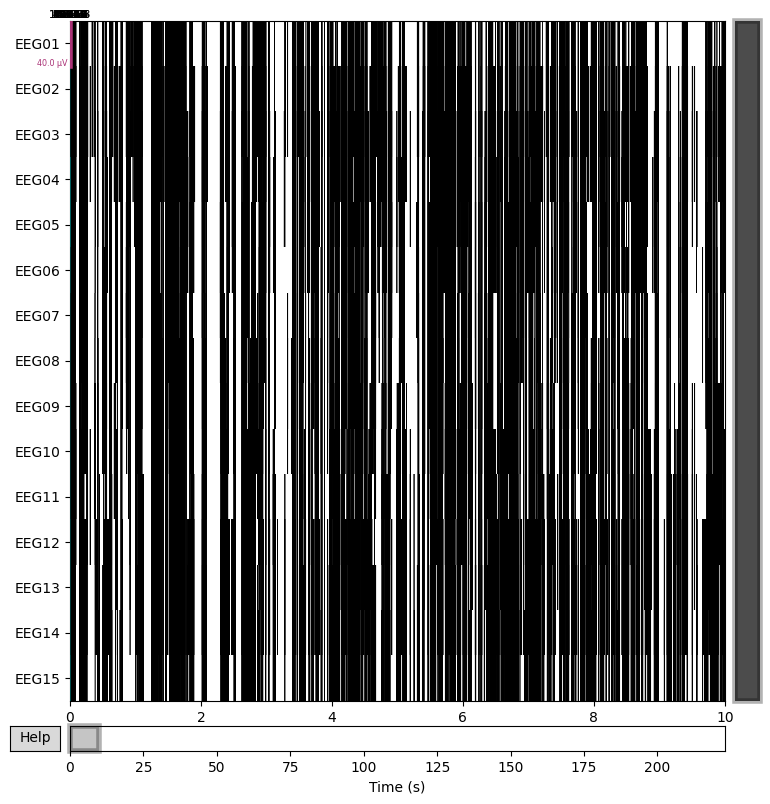

In [147]:
def create_info_from_subject(subject: Subject):
    if not isinstance(subject, Subject):
        raise TypeError("Expected a Subject instance")
    
    ch_names = [f"EEG{i:02d}" for i in range(1, subject.num_electrodes + 1)]
    ch_types = ["eeg"] * subject.num_electrodes
    info = mne.create_info(ch_names=ch_names, sfreq=subject.sampling_frequency, ch_types=ch_types)
    return info

def create_raw_from_subject(subject: Subject, run: int):
    info = create_info_from_subject(subject)
    data = subject.get_run_data(run)
    raw = mne.io.RawArray(data.T, info)

    run_object = subject[run]
    events = np.column_stack(
        (
            np.array(run_object.markers.T, dtype=int),
            np.zeros(20, dtype=int),
            np.array(run_object.cue_id.T, dtype=int),
        )
    )

    event_dict={}
    for i in range(len(run_object.classes)):
        event_dict[run_object.classes[i]]=i+1
    
    return raw, events, event_dict

info = create_info_from_subject(subjects[1])
print(info)
raw, events, event_dict = create_raw_from_subject(subjects[1], 0)
raw.plot(events=events, event_id = event_dict)

In [134]:
import mne

# Example data extraction from a Run instance
# Assuming 'run' is an instance of your Run class
run = subjects[1][1]
print(run)
eeg_data = run.data.T  # Transpose data to shape (n_channels, n_samples)
sfreq = run.fs  # Sampling frequency

# Create channel names (e.g., ['EEG001', 'EEG002', ..., 'EEG015'])
ch_names = [f'EEG{i:03}' for i in range(1, eeg_data.shape[0] + 1)]

# Create info object
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')

# Create RawArray object
raw = mne.io.RawArray(eeg_data, info)

# Now `raw` is an MNE Raw object containing your EEG data

# Assuming 'run' is an instance of your Run class with 'markers' and 'cue_id' attributes
# 'markers' is a list or array of sample numbers where events occur
# 'cue_id' is a list or array of the same length as 'markers' with event identifiers

# Create the events array
# Column 1: Sample numbers
# Column 2: Zeros (no previous event value)
# Column 3: Event identifiers
events = np.column_stack([np.array(run.markers), np.zeros_like(run.markers), np.array(run.cue_id)])

# Add events to the Raw object
raw.add_events(events, stim_channel=None)

Run: 
	Data: (112128, 15), 
	Markers: (1, 20), 
	Cue IDs: (1, 20), 
	Sampling Frequency: 512, 
	Classes: ['right hand', 'feet']
(15, 112128)
Creating RawArray with float64 data, n_channels=15, n_times=112128
    Range : 0 ... 112127 =      0.000 ...   218.998 secs
Ready.


ValueError: events must be shape (n_events, 3)